# C3 FC percentile validation

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the`DEA Sandbox` environments
* **Products used:** 
[fc_percentile_albers_annual](https://explorer.sandbox.dea.ga.gov.au/products/fc_percentile_albers_annual), 
C3 fc percentile test product

## Description
The notebook is to validate the new C3 fc percentile product against the C2 product `fc_percentile_albers_annual`. It produced the output for the validation report.

1. Generate distritubtions and plot PDFs as the validation results
2. Produce the summary of validation results
3. Plot examples of the findings

***

## Getting started

Install the package needed by

`!pip install awswrangler`

in the top cell or the terminal then restart notebook.

In [1]:
import datacube
import rasterio
import boto3
import xarray as xr
import numpy as np
import re
from datacube.utils.dask import start_local_dask
from datacube import Datacube
from osgeo import ogr, gdal, osr
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as sps
import awswrangler as wr
import rioxarray as rxr

In [2]:
# create a local cluster
client = start_local_dask(n_workers=1, threads_per_worker=60, memory_limit='460GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 60,Total memory: 428.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33481,Workers: 1
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Total threads: 60
Started: Just now,Total memory: 428.41 GiB
Comm: tcp://127.0.0.1:45353,Total threads: 60
Dashboard: /user/emma.ai@ga.gov.au/proxy/42489/status,Memory: 428.41 GiB
Nanny: tcp://127.0.0.1:35235,


In [56]:
client.close()

In [3]:
# `dev` is the credential profile name
# change it accordingly
# session = boto3.Session(profile_name='dev')
session = None

In [5]:
# list all the available file paths/prefix
fc_bucket = "s3://dea-public-data-dev/test/fc-new-percentiles/"
fc_x_dirs = wr.s3.list_directories(fc_bucket, boto3_session=session)
fc_file_dirs = []
for x_idx in fc_x_dirs:
    fc_file_dirs += wr.s3.list_directories(x_idx, boto3_session=session)

In [18]:
!aws s3 rm  s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/ --recursive

delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x08_y31_c3_dilation.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x12_y20_c3_dilation.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x12_y19_c3_new.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x12_y19_c3_dilation.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x08_y31_c3_new.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x24_y40_c3_dilation.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x17_y37_c3_dilation.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x17_y37_c3_new.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x12_y20_c3_new.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x18_y37_c3_dilation.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/x18_y37_c3_new.csv
delete: s3://dea-public-data-dev/fcp_comparison_re_new_fc

In [20]:
!aws s3 cp  fcp_diff_plot/ s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/ --recursive

upload: fcp_diff_plot/all_tiles_mean_diff.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/all_tiles_mean_diff.png
upload: fcp_diff_plot/x24_y40.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x24_y40.png
upload: fcp_diff_plot/x18_y37.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x18_y37.png
upload: fcp_diff_plot/x27_y42.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x27_y42.png
upload: fcp_diff_plot/x12_y19.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x12_y19.png
upload: fcp_diff_plot/x27_y43.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x27_y43.png
upload: fcp_diff_plot/x12_y20.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x12_y20.png
upload: fcp_diff_plot/x28_y42.png to s3://dea-public-data-dev/fcp_comparison_re_new_fc_model/fcp_diff_plot/x28_y42.png
upload: fcp_diff_plot/x1

In [6]:
fc_file_dirs

['s3://dea-public-data-dev/test/fc-new-percentiles/x08/y31/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x12/y19/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x12/y20/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x17/y37/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x18/y37/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x24/y40/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x27/y42/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x27/y43/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x28/y42/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x28/y43/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x31/y40/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x34/y17/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x37/y36/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x38/y37/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x38/y40/',
 's3://dea-public-data-dev/test/fc-new-percentiles/x39/y13/',
 's3://d

In [7]:
# list all the available file paths/prefix
fc_y_bucket = "s3://dea-public-data-dev/test/fc-percentile-dilation-6/"

In [8]:
def generate_seamask(shape_file, data_shape, orig_coords, resolution):
    """
        creak mask without oceans
        input:
            shape_file: the shape file of Australia coastline
            data_shape: the shape of loaded data to be masked upon
            orig_coords: the origin of the image for gdal to decide the transform
            resolution: pixel size with signs, e.g., (30, -30) for C3 and (25, -25) for C2
        output:
            a numpy array of mask, where valid pixels = 1
    """
    source_ds = ogr.Open(shape_file)
    source_layer = source_ds.GetLayer()
    source_layer.SetAttributeFilter("FEAT_CODE!='sea'")

    yt, xt = data_shape
    xres = resolution[0]
    yres = resolution[1]
    no_data = 0

    xcoord, ycoord = orig_coords
    geotransform = (xcoord - (xres*0.5), xres, 0, ycoord - (yres*0.5), 0, yres)

    target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    albers = osr.SpatialReference()
    albers.ImportFromEPSG(3577)
    target_ds.SetProjection(albers.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(no_data)

    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    return band.ReadAsArray()


In [9]:
def random_samples(input_array, pixel_size, size_div=150*150):
    """
        randomly sample the data with replacement
        input:
            input_array: the array of data to sample
            pixel_size: area of a pixel, e.g., 30^2 for C3 and 25^2 for C2
            size_div: area which includes integer numbers of pixels for both C2 and C3, default 150^2
        output:
            mean and variance of the random samples
    """
    sample_mean = 0
    sample_var = 0
    tmp_array = input_array.reshape(-1)
    tmp_array = tmp_array[~np.isnan(tmp_array)]
    size_d = size_div / pixel_size * 1e3
    if size_d >= tmp_array.size:
        sample_array = tmp_array
        sample_mean = tmp_array.mean()
        sample_var = np.var(sample_array)
    else:
        batches = tmp_array.size // size_d * 2
        for i in range(int(batches)):
            sample_array = tmp_array[np.random.randint(0, int(tmp_array.size), int(size_d))]
            sample_mean += sample_array.mean()
            sample_var += np.var(sample_array)
    return (sample_mean/batches, sample_var/batches)

1.1 Generate mean and variance for each grid in the list
-----

In [11]:
dc = Datacube()
var_list = ["pv_pc_", "npv_pc_", "bs_pc_"]
perc_list = ["10", "50", "90"]
i = 0
pd_columns = []
for v in var_list:
    for p in perc_list:
        pd_columns += [v+p+'_mean']
        pd_columns += [v+p+'_var']

In [21]:
# loop over the path/prefix of all the test grids
for f_dir in fc_file_dirs:
    dataset = None
    for i in range(1987, 2023):
        # get the path/prefix of every year for the grid
        non_empty_list = wr.s3.list_objects(f_dir + str(i), boto3_session=session, suffix=['tif'])
        if non_empty_list == []:
            continue
        tmp_set = []
        # load all the data into dask array and named by the year
        for o in non_empty_list:
            data = rxr.open_rasterio(o, chunks={'x':1600, 'y':1600})
            data.name = re.findall(r'(?<=P1Y_final_)\w+', o)[0]
            tmp_set += [data]
        # make the xarray the similar format as C2
        tmp_set = xr.merge(tmp_set)
        tmp_set = tmp_set.rename_dims({'band': 'time'})
        tmp_set = tmp_set.rename_vars({'band': 'time'})
        tmp_set.time.data[0] = i
        if dataset is None:
            dataset = tmp_set
        else:
            dataset = xr.concat([dataset, tmp_set], dim='time')
    # mask nodata
    re_c3_new = dataset.where(dataset.qa==2)
    
    dataset = None
    fc_y_dir = fc_y_bucket + "/".join(f_dir.split('/')[-3:-1]) + "/"
    for i in range(1987, 2023):
        # get the path/prefix of every year for the grid
        non_empty_list = wr.s3.list_objects( fc_y_dir + str(i), boto3_session=session, suffix=['tif'])
        if non_empty_list == []:
            continue
        tmp_set = []
        # load all the data into dask array and named by the year
        for o in non_empty_list:
            data = rxr.open_rasterio(o, chunks={'x':1600, 'y':1600})
            data.name = re.findall(r'(?<=P1Y_final_)\w+', o)[0]
            tmp_set += [data]
        # make the xarray the similar format as C2
        tmp_set = xr.merge(tmp_set)
        tmp_set = tmp_set.rename_dims({'band': 'time'})
        tmp_set = tmp_set.rename_vars({'band': 'time'})
        tmp_set.time.data[0] = i
        if dataset is None:
            dataset = tmp_set
        else:
            dataset = xr.concat([dataset, tmp_set], dim='time')
    # mask nodata
    re_c3_dilation = dataset.where(dataset.qa==2)
    
    c3_land_raster = generate_seamask("/home/jovyan/aus_map/cstauscd_r_3577.shp", re_c3_new.pv_pc_10.shape[1:], (re_c3_new.x.data.min(), re_c3_new.y.data.max()), (30, -30))
    # init panda dataframe to save the results
    results_c3_new = pd.DataFrame(columns=pd_columns, index=np.arange(1987, 2023))
    results_c3_dilation = pd.DataFrame(columns=pd_columns, index=np.arange(1987, 2023))
    
    print("start load data")
    re_c3_new.load()
    re_c3_dilation.load()
    # compute mean and variance for each band and each year
    for y in range(1987, 2023):
        for v in var_list:
            for p in perc_list:
                results_c3_new.loc[y, v+p+'_mean'], results_c3_new.loc[y, v+p+'_var'] = random_samples(re_c3_new[v+p].loc[dict(time=y)].where(c3_land_raster > 0).data, 30**2)
                results_c3_dilation.loc[y, v+p+'_mean'], results_c3_dilation.loc[y, v+p+'_var'] = random_samples(re_c3_dilation[v+p].loc[dict(time=y)].where(c3_land_raster > 0).data, 30**2)
    # save the results to csvs
    # named after grid index and product version, e.g., x14_y29_c2.csv
    results_c3_new.to_csv('_'.join(f_dir.split('/')[-3:-1])+'_c3_new.csv')
    results_c3_dilation.to_csv('_'.join(f_dir.split('/')[-3:-1])+'_c3_dilation.csv')
    break

start load data


2024-02-07 00:31:22,676 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-02-07 00:31:24,576 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-02-07 00:31:29,083 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-02-07 00:31:31,436 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-02-07 00:31:34,095 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-02-07 00:31:38,657 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-02-07 00:35:47,022 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-02-07 00:37:52,893 - distributed.utils_perf - WARNING - full garbage collections took

TypeError: 'float' object cannot be interpreted as an integer

In [25]:
    for y in range(1987, 2023):
        for v in var_list:
            for p in perc_list:
                results_c3_new.loc[y, v+p+'_mean'], results_c3_new.loc[y, v+p+'_var'] = random_samples(re_c3_new[v+p].loc[dict(time=y)].where(c3_land_raster > 0).data, 30**2)
                results_c3_dilation.loc[y, v+p+'_mean'], results_c3_dilation.loc[y, v+p+'_var'] = random_samples(re_c3_dilation[v+p].loc[dict(time=y)].where(c3_land_raster > 0).data, 30**2)
    # save the results to csvs
    # named after grid index and product version, e.g., x14_y29_c2.csv
    results_c3_new.to_csv('_'.join(f_dir.split('/')[-3:-1])+'_c3_new.csv')
    results_c3_dilation.to_csv('_'.join(f_dir.split('/')[-3:-1])+'_c3_dilation.csv')

7.9523563
7.7914968
7.119941
8.365996
8.288365
8.457969
7.2720923
7.0880027
8.251367
7.7390985
7.4887776
6.57589
7.6762724
7.9202538
7.6371317
7.0379205
7.2692504
6.9676223
7.979594
6.8864346
7.701988
7.1834254
7.9935718
7.8883586
7.773591
7.1016817
8.477523
8.086872
8.085017
7.886282
15.34957
14.83194
15.594088
15.786696
15.188096
15.018509
14.911775
15.471983
16.202599
15.789405
15.27008
15.854732
15.441921
15.920318
15.911174
15.527985
14.934525
15.39419
15.816568
16.071308
15.309064
15.805312
14.893385
15.083285
15.134296
16.5528
16.180346
16.682817
15.986841
15.870255
9.308702
9.4289875
9.942803
9.475348
9.67543
8.734327
9.555305
9.473768
8.895814
8.900244
9.829424
10.607621
9.601431
9.677532
9.015719
8.806484
9.217958
8.784815
9.594024
11.443969
9.499794
9.072367
8.593004
9.755945
9.3179
9.700794
9.254309
9.066603
9.573746
8.409999
18.608189
18.371857
18.939953
19.18662
19.423368
20.24826
18.920103
19.005686
19.242144
19.38852
18.598145
19.390486
19.533224
19.08265
19.33482
18.65

In [32]:
np.sqrt(np.var(np.random.random(100)*100))

27.467795438593143

In [19]:
np.nanmean(re_c3_new[v+p].loc[dict(time=y)].where(c3_land_raster > 0).data)

23.127378

In [80]:
# loop over the path/prefix of all the test grids
for f_dir in fc_file_dirs:
    dataset = None
    for i in range(1987, 2021):
        # get the path/prefix of every year for the grid
        non_empty_list = wr.s3.list_objects(f_dir + str(i), boto3_session=session, suffix=['tif'])
        if non_empty_list == []:
            continue
        tmp_set = []
        # load all the data into dask array and named by the year
        for o in non_empty_list:
            data = xr.open_rasterio(o, chunks={'x':3200, 'y':3200})
            data.name = re.findall(r'(?<=P1Y_)\w+', o)[0]
            tmp_set += [data]
        # make the xarray the similar format as C2
        tmp_set = xr.merge(tmp_set)
        tmp_set = tmp_set.rename_dims({'band': 'time'})
        tmp_set = tmp_set.rename_vars({'band': 'time'})
        tmp_set.time.data[0] = i
        if dataset is None:
            dataset = tmp_set
        else:
            dataset = xr.concat([dataset, tmp_set], dim='time')
    # mask nodata
    re_c3 = dataset.where(dataset.qa==2, 0)
    # query and load C2 by the geolocation of grid
    query = {'time':('1987-01-01', '2021-01-01'), 'x': (re_c3.x.data.min() - 15, re_c3.x.data.max() + 15), 'y': (re_c3.y.data.min() - 15, re_c3.y.data.max() + 15), 'crs': 'EPSG:3577'}
    c2_data = dc.load(product='fc_percentile_albers_annual', **query, dask_chunks={'time':1})
    # mask nodata
    re_c2 = c2_data.where(c2_data > -1, 0)
    
    # generate raster of oceans mask
    c2_land_raster = generate_seamask("aus_map/cstauscd_r_3577.shp", re_c2.PV_PC_10.shape[1:], (re_c2.x.data.min(), re_c2.y.data.max()), (25, -25))
    c3_land_raster = generate_seamask("aus_map/cstauscd_r_3577.shp", re_c3.pv_pc_10.shape[1:], (re_c3.x.data.min(), re_c3.y.data.max()), (30, -30))
    # init panda dataframe to save the results
    results_c2 = pd.DataFrame(columns=pd_columns, index=np.arange(1987, 2021))
    results_c3 = pd.DataFrame(columns=pd_columns, index=np.arange(1987, 2021))
    
    print("start load data")
    re_c3.load()
    re_c2.load()
    # compute mean and variance for each band and each year
    for y in range(1987, 2021):
        for v in var_list:
            for p in perc_list:
                results_c3.loc[y, v+p+'_mean'], results_c3.loc[y, v+p+'_var'] = random_samples(re_c3[v+p].loc[dict(time=y)].where(c3_land_raster > 0, 0).data, 30**2)
                results_c2.loc[y, v+p+'_mean'], results_c2.loc[y, v+p+'_var'] = random_samples(re_c2[v.upper()+p].loc[dict(time=str(y)+'-01-01')].where(c2_land_raster > 0, 0).data, 25**2)
    # save the results to csvs
    # named after grid index and product version, e.g., x14_y29_c2.csv
    results_c2.to_csv('_'.join(f_dir.split('/')[-3:-1])+'_c2.csv')
    results_c3.to_csv('_'.join(f_dir.split('/')[-3:-1])+'_c3.csv')

AttributeError: module 'xarray' has no attribute 'open_rasterio'

1.2. Plot PDFs of each grid with the mean and variance saved in csvs
--------------------

In [43]:
for f_dir in fc_file_dirs:
    tile_name = '_'.join(f_dir.split('/')[-3:-1])
    if os.path.exists(tile_name+'.png'):
        continue
    # read in results from csvs
    results_c2 = pd.read_csv(tile_name+'_c3_dilation.csv', index_col=0)
    results_c3 = pd.read_csv(tile_name+'_c3_new.csv', index_col=0)
    fig, axs = plt.subplots(36, 9,  sharey=True, sharex=True, figsize=(20, 60))
    i = 0
    j = 0
    # plot PDFs for each year and each band
    for y in range(1987, 2023):
        for v in var_list:
            for p in perc_list:
                x = np.arange(results_c3.loc[y, v+p+'_mean']-2*np.sqrt(results_c3.loc[y, v+p+'_var']), results_c3.loc[y, v+p+'_mean']+2*np.sqrt(results_c3.loc[y, v+p+'_var']), 1)
                axs[j, i].plot(norm.pdf(x, results_c3.loc[y, v+p+'_mean'], np.sqrt(results_c3.loc[y, v+p+'_var'])), label='C3-new distribution', color='darkblue')
                x = np.arange(results_c2.loc[y, v+p+'_mean']-2*np.sqrt(results_c2.loc[y, v+p+'_var']), results_c2.loc[y, v+p+'_mean']+2*np.sqrt(results_c2.loc[y, v+p+'_var']), 1)
                axs[j, i].plot(norm.pdf(x, results_c2.loc[y, v+p+'_mean'], np.sqrt(results_c2.loc[y, v+p+'_var'])), label='C3-dilation distribution', color='darkorange')
                # set title of columns of plotting grid
                if j == 0:
                    axs[j, i].set_title(v+p)
                # set title of rows of plotting grid
                if i == 0:
                    axs[j, i].set_ylabel(str(y), rotation=90, size='large')
                i += 1
        j += 1
        i = 0
    plt.tight_layout()
    # plot legends shared by all subplots
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    fig.savefig(tile_name+'.png')
    print("plot", tile_name)
    plt.close()

plot x08_y31
plot x12_y19
plot x12_y20
plot x17_y37
plot x18_y37
plot x24_y40
plot x27_y42
plot x27_y43
plot x28_y42
plot x28_y43
plot x31_y40
plot x34_y17
plot x37_y36
plot x38_y37
plot x38_y40
plot x39_y13
plot x39_y38
plot x40_y13
plot x40_y38
plot x42_y37
plot x42_y38
plot x43_y35
plot x45_y15
plot x45_y16
plot x45_y17
plot x46_y17
plot x48_y27
plot x49_y23
plot x49_y24


2.. Plot the summary of the validation results
-------

In [12]:
# define the columns to summarize
mean_columns = []
for v in var_list:
    for p in perc_list:
        mean_columns += [v+p+'_mean']

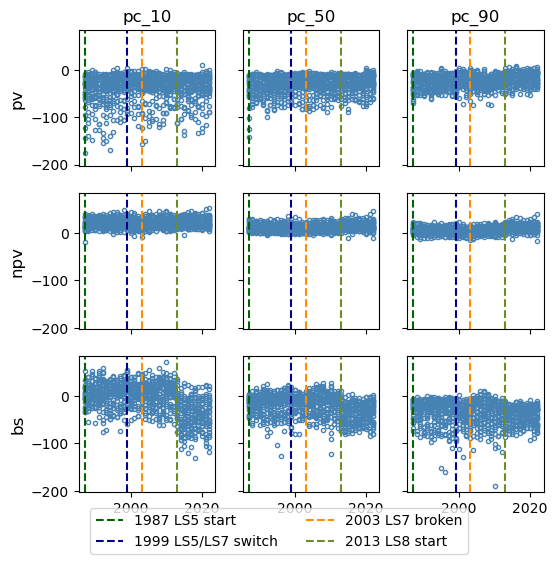

In [13]:
# scatter plot the difference of mean for all testing grids in the list
fig, axs = plt.subplots(3, 3,  sharey=True, sharex=True, figsize=(6, 6))
for f_dir in fc_file_dirs:
    tile_name = '_'.join(f_dir.split('/')[-3:-1])
    # if tile_name in ['x40_y13', 'x43_y15', 'x45_y17']:
    #    continue
    # read in the results saved in the csvs
    results_c2 = pd.read_csv(tile_name+'_c3_dilation.csv', index_col=0)
    results_c3 = pd.read_csv(tile_name+'_c3_new.csv', index_col=0)
    # compute the difference of mean for all the bands
    mean_diff = (results_c3[mean_columns] - results_c2[mean_columns])/results_c3[mean_columns] * 100
    i = 0
    j = 0
    # scatter plot the differences
    for v in var_list:
        for p in perc_list:
            axs[i, j].plot(mean_diff[v+p+'_mean'], 'o', color='SteelBlue',  mfc='none', markersize=3)
            # set title of columns of plotting grid
            if i == 0:
                axs[i, j].set_title('pc_'+str(p))
            # set title of rows of plotting grid
            if j == 0:
                axs[i, j].set_ylabel(v.split('_')[0], rotation=90, size='large')
            j += 1
        i += 1
        j = 0
# mark the crutial time points
for i in range(3):
    for j in range(3):
        axs[i, j].axvline(x=1987, linestyle='--', color='darkgreen', label='1987 LS5 start')
        axs[i, j].axvline(x=1999, linestyle='--', color='darkblue', label='1999 LS5/LS7 switch')
        axs[i, j].axvline(x=2003, linestyle='--', color='darkorange', label='2003 LS7 broken')
        axs[i, j].axvline(x=2013, linestyle='--', color='OliveDrab', label='2013 LS8 start')
# plot the legends shared by all subplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)
fig.savefig("all_tiles_mean_diff.png", bbox_inches='tight')

/tmp/ipykernel_9701/1515457671.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_diff = mean_diff.append(results_c3[mean_columns] - results_c2[mean_columns])
/tmp/ipykernel_9701/1515457671.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_diff = mean_diff.append(results_c3[mean_columns] - results_c2[mean_columns])
/tmp/ipykernel_9701/1515457671.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_diff = mean_diff.append(results_c3[mean_columns] - results_c2[mean_columns])
/tmp/ipykernel_9701/1515457671.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_diff = mean_diff.append(results_c3[mean_columns] - result

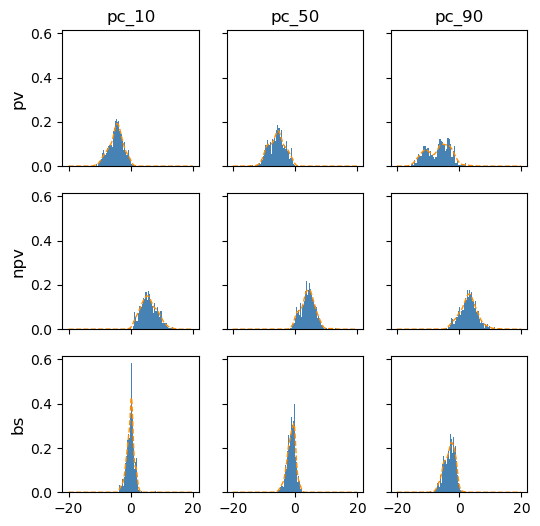

In [14]:
# histgram plot for the difference of mean for all testing grids in the list
fig, axs = plt.subplots(3, 3,  sharey=True, sharex=True, figsize=(6, 6))
mean_diff = None
# compute the difference of mean for all grids
for f_dir in fc_file_dirs:
    tile_name = '_'.join(f_dir.split('/')[-3:-1])
    # if tile_name in ['x40_y13', 'x43_y15', 'x45_y17']:
    #     continue
    results_c2 = pd.read_csv(tile_name+'_c3_dilation.csv', index_col=0)
    results_c3 = pd.read_csv(tile_name+'_c3_new.csv', index_col=0)
    if mean_diff is None:
        mean_diff = results_c3[mean_columns] - results_c2[mean_columns]
    else:
        mean_diff = mean_diff.append(results_c3[mean_columns] - results_c2[mean_columns])
i = 0
j = 0
for v in var_list:
    for p in perc_list:
        # histgram plot for each band
        axs[i, j].hist(mean_diff[v+p+'_mean'].to_numpy(), color='SteelBlue', bins=50, density=True)
        kde = sps.gaussian_kde(mean_diff[v+p+'_mean'].to_numpy())
        axs[i, j].plot(np.arange(-20, 20, 0.1), kde.pdf(np.arange(-20, 20, 0.1)), color='darkorange', linestyle='--', linewidth=1)
        if i == 0:
            axs[i, j].set_title('pc_'+str(p))
        if j == 0:
            axs[i, j].set_ylabel(v.split('_')[0], rotation=90, size='large')
        j += 1
    i += 1
    j = 0
fig.savefig("all_tiles_hist.png", bbox_inches='tight')

3.. Plot FC percentile band of any testing grid
---------------------

In [ ]:
# plot fc percentile band as required
# reading data is the same as in the loop of computation above
f_dir = fc_bucket + 'x45/y17/'
dataset = None
for i in range(1987, 2021):
    non_empty_list = wr.s3.list_objects(f_dir + str(i), boto3_session=session, suffix=['tif'])
    if non_empty_list == []:
        continue
    tmp_set = []
    for o in non_empty_list:
        data = xr.open_rasterio(o, chunks={'x':3200, 'y':3200})
        data.name = re.findall(r'(?<=P1Y_)\w+', o)[0]
        tmp_set += [data]
    tmp_set = xr.merge(tmp_set)
    tmp_set = tmp_set.rename_dims({'band': 'time'})
    tmp_set = tmp_set.rename_vars({'band': 'time'})
    tmp_set.time.data[0] = i
    if dataset is None:
        dataset = tmp_set
    else:
        dataset = xr.concat([dataset, tmp_set], dim='time')
re_c3 = dataset.where(dataset.qa==2)
query = {'time':('1987-01-01', '2021-01-01'), 'x': (re_c3.x.data.min() - 15, re_c3.x.data.max() + 15), 'y': (re_c3.y.data.min() - 15, re_c3.y.data.max() + 15), 'crs': 'EPSG:3577'}
c2_data = dc.load(product='fc_percentile_albers_annual', **query, dask_chunks={'time':1})
re_c2 = c2_data.where(c2_data > -1)

c2_land_raster = generate_seamask("aus_map/cstauscd_r_3577.shp", re_c2.PV_PC_10.shape[1:], (re_c2.x.data.min(), re_c2.y.data.max()), (25, -25))
c3_land_raster = generate_seamask("aus_map/cstauscd_r_3577.shp", re_c3.pv_pc_10.shape[1:], (re_c3.x.data.min(), re_c3.y.data.max()), (30, -30))

In [ ]:
# plot the valid data for a band
re_c3.pv_pc_10.loc[dict(time=2018)].where(c3_land_raster > 0).compute().plot(aspect=1.5, size=10)
plt.savefig('x45y17_2018_c3.png', bbox_inches='tight')

In [ ]:
# title too long for C2, drop spatial_ref: 3577
re_c2 = re_c2.drop_vars('spatial_ref')

In [ ]:
# plot the valid data for a band
re_c2.PV_PC_10.loc[dict(time='2018-01-01')].where(c2_land_raster > 0).compute().plot(aspect=1.5, size=10)
plt.savefig('x45y17_2018_c2.png', bbox_inches='tight')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2021

**Compatible datacube version:** 

In [125]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 8`, :index:`landsat 7`, :index: `landsat 5`, :index: `fc percentile`